# Paper reproduction: *Cancer diagnosis in histopathological image: CNN based approach*

## Dataset: *BreakHis*

---

### Data wrangling

In [1]:
!pip install matplotlib==3.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 10.3 MB 4.3 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [1]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import tensorflow as tf

from functools import partial
from keras import backend as K
from keras import callbacks
from sklearn.metrics import auc, classification_report, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses, models
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Input, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import plot_model

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
!ls drive/MyDrive
folds = pd.read_csv("./drive/MyDrive/ColabNotebooks/Folds.csv")

Classroom  ColabNotebooks


In [4]:
folds.head()

,fold,mag,grp,filename
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
3,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
4,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...


In [5]:
df = pd.DataFrame(folds.iloc[:7909])
df.head()

,fold,mag,grp,filename
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
3,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
4,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...


In [7]:
df["label"] = df["filename"].apply(lambda x: x.split("/")[3])
df.head()

,fold,mag,grp,filename,label
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign
3,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign
4,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign


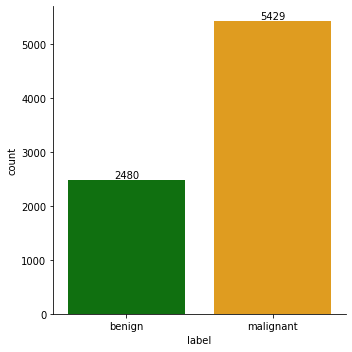

In [8]:
g = sns.catplot(x="label", data=df, kind="count", palette=['green', 'orange'])
for ax in g.axes.flat:
    ax.bar_label(ax.containers[0])
plt.show()

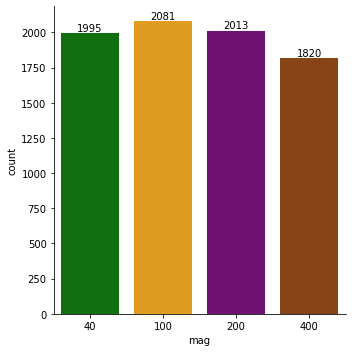

In [ ]:
g = sns.catplot(x="mag", data=df, kind="count", palette=['green', 'orange', 'purple', "#9a4204"])
for ax in g.axes.flat:
    ax.bar_label(ax.containers[0])
plt.show()

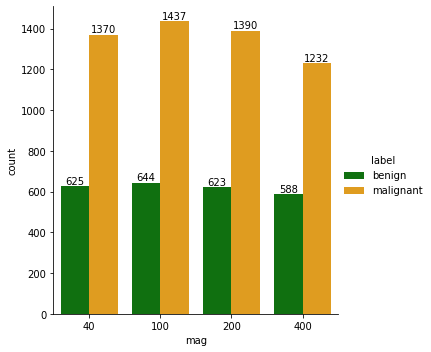

In [ ]:
g = sns.catplot(x="mag", data=df, hue="label", kind="count", palette=['green', 'orange'])
for ax in g.axes.flat:
    for c in ax.containers:
        ax.bar_label(c)
plt.show()

---

### Split the data and load images

In [ ]:
df['label_int'] = df.label.apply(lambda x: ['benign', 'malignant'].index(x))

In [ ]:
df

,fold,mag,grp,filename,label,label_int
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,0
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,0
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,0
3,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,0
4,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,0
...,...,...,...,...,...,...
7904,1,400,test,BreaKHis_v1/histology_slides/breast/malignant/...,malignant,1
7905,1,400,test,BreaKHis_v1/histology_slides/breast/malignant/...,malignant,1
7906,1,400,test,BreaKHis_v1/histology_slides/breast/malignant/...,malignant,1
7907,1,400,test,BreaKHis_v1/histology_slides/breast/malignant/...,malignant,1


In [ ]:
random_state = 42

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df["filename"], df["label_int"], test_size=0.2, random_state=42)

In [ ]:
train_loader = tf.data.Dataset.from_tensor_slices(("./drive/MyDrive/ColabNotebooks/BreaKHis_v1/" + X_train, y_train))
test_loader = tf.data.Dataset.from_tensor_slices(("./drive/MyDrive/ColabNotebooks/BreaKHis_v1/" + X_test, y_test))

In [ ]:
def parse_image(path, label):
    """
    Reads image data for given path.
    """
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    return img, label


def resize_rescale(image, label):
    """
    Resizes given image to desired size.
    """
    img = tf.cast(image, tf.float32)
    img = tf.image.resize(img, [64, 64]) / 255
    return img, label

In [ ]:
X_trainset = train_loader.shuffle(len(X_train)).map(parse_image).map(resize_rescale).batch(64)
X_testset = test_loader.shuffle(len(X_test)).map(parse_image).map(resize_rescale).batch(64)

### Visualize a dataset sample

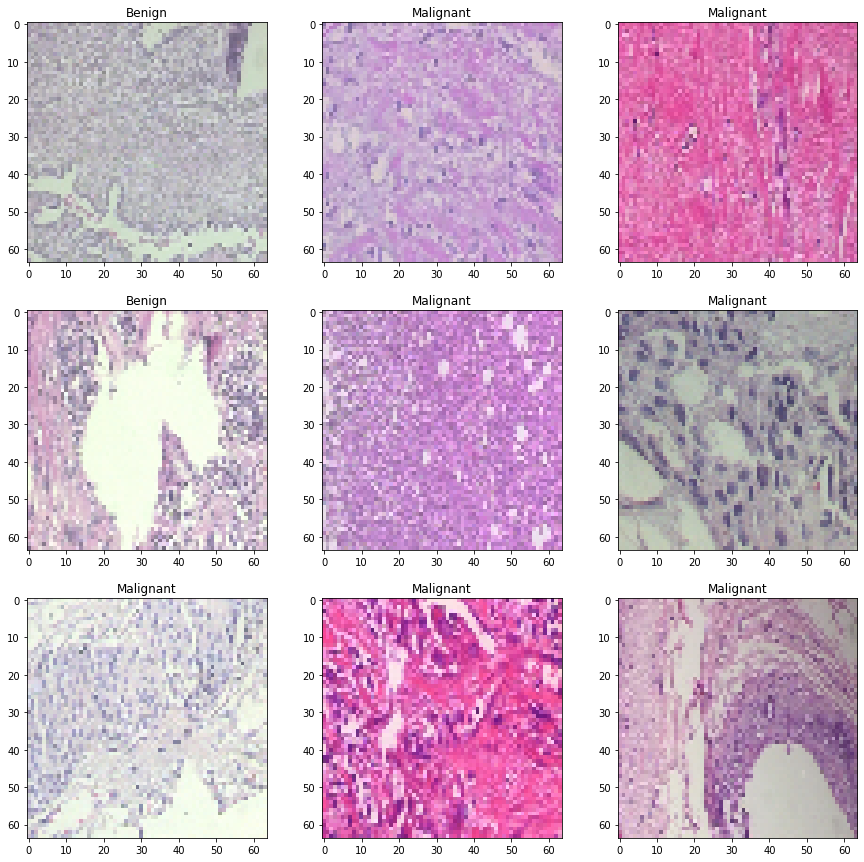

In [ ]:
fig = plt.figure(figsize=(15, 15))
for i, img in enumerate(X_trainset):
    if i == 9:
        break
    ax = fig.add_subplot(3, 3, i+1)
    if tf.keras.backend.get_value(img[1][i]) == 0:
       ax.title.set_text("Benign")
    else:
       ax.title.set_text("Malignant")
    plt.imshow(img[0][i])
plt.show()

---

### Build and evaluate a model

Created model: *convolutional neural network* + *fully-connected layer*.



In [ ]:
img_shape = (64, 64, 3)

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, 5, padding='same', activation='relu', strides=(1, 1), input_shape=img_shape))
model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(1, 1)))
model.add(layers.Conv2D(64, 5, activation='relu', strides=(1, 1)))
model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(1, 1)))
model.add(layers.Conv2D(128, 5, activation='relu', strides=(1, 1)))
model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(1, 1)))

In [ ]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(2, activation="softmax"))

In [ ]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics= ["accuracy"])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 64, 64, 32)        2432      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 58, 58, 64)        51264     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 52, 52, 128)       204928    
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 50, 50, 128)     

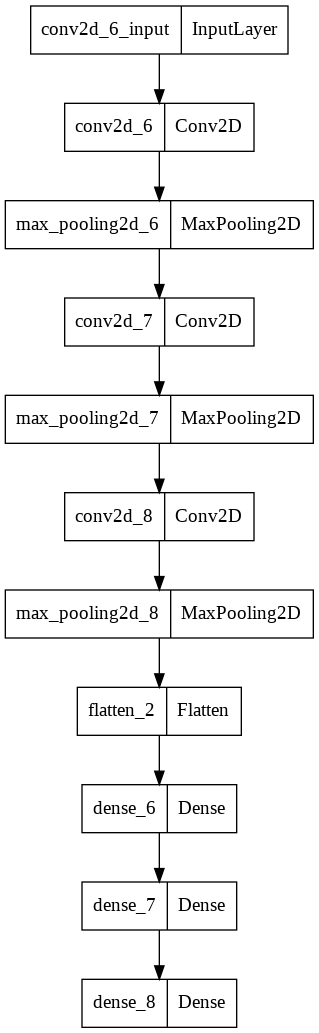

In [ ]:
plot_model(model, 'model.png')

In [ ]:
def plotTrainingHistory(model):
    history = model.history

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.plot(history['accuracy'], label='train')
    ax1.plot(history['val_accuracy'], label='validation')
    ax1.set_title('Accuracy')
    ax1.set_ylabel('Accuracy score')
    ax1.set_xlabel('Epoch')
    ax1.legend()

    ax2.plot(history['loss'], label='train')
    ax2.plot(history['val_loss'], label='validation')
    ax2.set_title('Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend()
    plt.show()

In [ ]:
earlystopping = callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=5, restore_best_weights=True)

In [ ]:
history_model = model.fit(X_trainset, epochs=25, verbose=1, validation_data=(X_testset), callbacks=[earlystopping])

Epoch 1/25
99/99 [==============================] - 1222s 12s/step - loss: 0.6535 - accuracy: 0.6964 - val_loss: 0.5047 - val_accuracy: 0.7870
Epoch 2/25
99/99 [==============================] - 799s 8s/step - loss: 0.5126 - accuracy: 0.7792 - val_loss: 0.4672 - val_accuracy: 0.8205
Epoch 3/25
99/99 [==============================] - 790s 8s/step - loss: 0.4902 - accuracy: 0.8024 - val_loss: 0.4232 - val_accuracy: 0.8363
Epoch 4/25
99/99 [==============================] - 788s 8s/step - loss: 0.5093 - accuracy: 0.7820 - val_loss: 0.4831 - val_accuracy: 0.8293
Epoch 5/25
99/99 [==============================] - 787s 8s/step - loss: 0.4678 - accuracy: 0.8132 - val_loss: 0.4597 - val_accuracy: 0.8116
Epoch 6/25
99/99 [==============================] - 796s 8s/step - loss: 0.4776 - accuracy: 0.8040 - val_loss: 0.4888 - val_accuracy: 0.8003
Epoch 7/25
99/99 [==============================] - 794s 8s/step - loss: 0.4790 - accuracy: 0.8051 - val_loss: 0.4904 - val_accuracy: 0.7649
Epoch 8/25


In [ ]:
score_model = model.evaluate(X_testset)

25/25 [==============================] - 57s 2s/step - loss: 0.4054 - accuracy: 0.8420


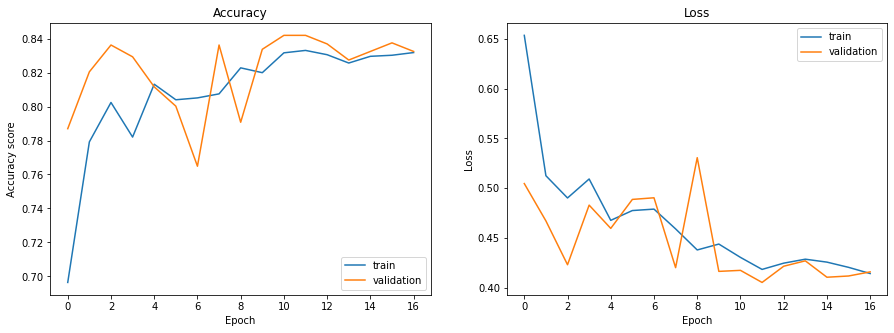

In [ ]:
plotTrainingHistory(history_model)

In [ ]:
y_test_pred = model.predict(X_testset)

In [ ]:
predicted_categories = tf.argmax(y_test_pred, axis=1)
true_categories = tf.concat([y for x, y in X_testset], axis=0)

In [ ]:
print(classification_report(true_categories, predicted_categories, target_names=["Benign", " Malignant"]))

              precision    recall  f1-score   support

      Benign       0.33      0.27      0.30       510
   Malignant       0.68      0.74      0.71      1072

    accuracy                           0.59      1582
   macro avg       0.50      0.50      0.50      1582
weighted avg       0.57      0.59      0.57      1582



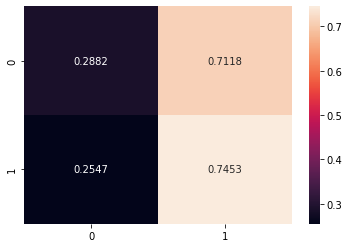

In [ ]:
conf_mat = confusion_matrix(true_categories, predicted_categories, normalize='true')
sns.heatmap(conf_mat, annot=True, fmt='.4g')

In [ ]:
def plotScoresHist(model, X_testset, conf_mat):
    scores = pd.DataFrame(conf_mat)
    classes = [0, 1]
    p = [scores[i].to_numpy()[i] / scores[i].to_numpy().sum() * 100
         for i in classes]
    plt.bar(["Benign", "Malignant"], p, color=['green', 'orange'])
    plt.title("percentage of correctly classified images")
    plt.xlabel('percentage')
    plt.ylabel('class')
    plt.xticks(["Benign", "Malignant"])
    plt.show()

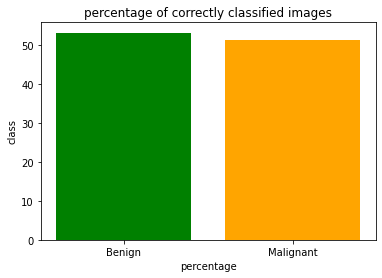

In [ ]:
plotScoresHist(model, X_testset, conf_mat)

---

#### Fit model for a part of the dataset

Due to technical reasons fitting model on full dataset for `500` epochs like in the paper was not achieveable, so the most optimal way was using a `EarlyStopping` feature to safe some time by reducing epochs number.

The goal of this project was getting as similar results as paper's authors have obtained, hence I chose to reduce the dataset to reduce fitting time.


In [ ]:
X_train1 = X_train.sample(frac=0.01, random_state=random_state)
y_train1 = y_train.sample(frac=0.01, random_state=random_state)

In [ ]:
X_test1 = X_test.sample(frac=0.01, random_state=random_state)
y_test1 = y_test.sample(frac=0.01, random_state=random_state)

In [ ]:
train_loader1 = tf.data.Dataset.from_tensor_slices(("./drive/MyDrive/ColabNotebooks/BreaKHis_v1/" + X_train1, y_train1))
test_loader1 = tf.data.Dataset.from_tensor_slices(("./drive/MyDrive/ColabNotebooks/BreaKHis_v1/" + X_test1, y_test1))

In [ ]:
X_trainset1 = train_loader.shuffle(len(X_train1)).map(parse_image).map(resize_rescale).batch(64)
X_testset1 = test_loader.shuffle(len(X_test1)).map(parse_image).map(resize_rescale).batch(64)

#### Visualize a sample of the smaller dataset

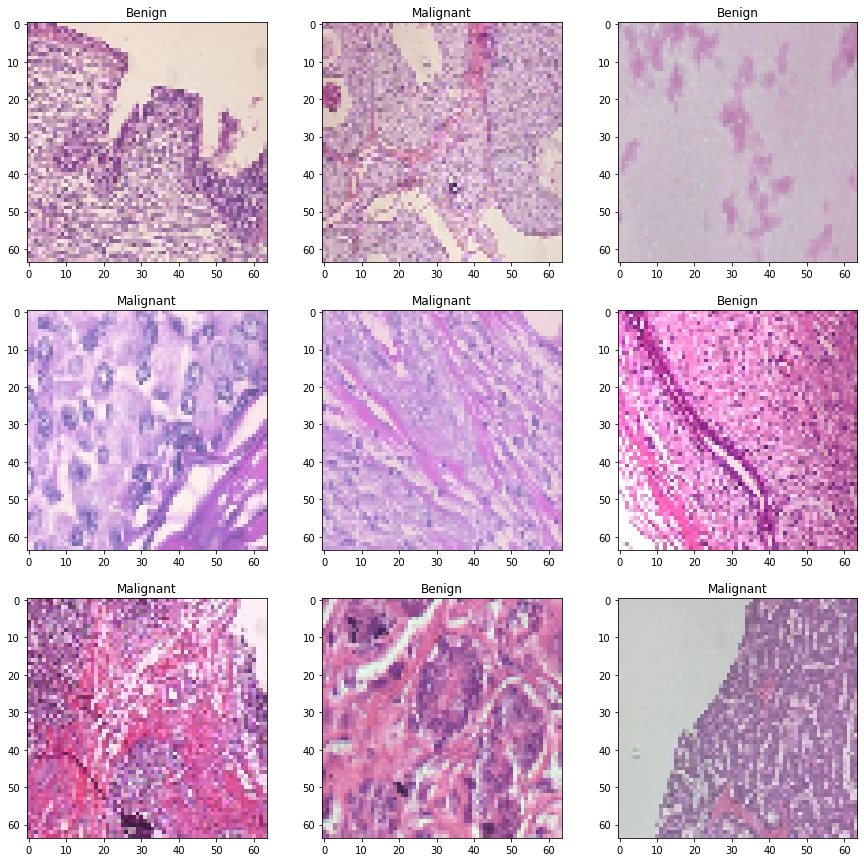

In [ ]:
fig = plt.figure(figsize=(15, 15))
for i, img in enumerate(X_trainset1):
    if i == 9:
        break
    ax = fig.add_subplot(3, 3, i+1)
    if tf.keras.backend.get_value(img[1][i]) == 0:
       ax.title.set_text("Benign")
    else:
       ax.title.set_text("Malignant")
    plt.imshow(img[0][i])
plt.show()

In [ ]:
history_model_1 = model.fit(X_trainset1, epochs=5, verbose=1, validation_data=(X_testset1))

Epoch 1/5
99/99 [==============================] - 1075s 11s/step - loss: 0.4258 - accuracy: 0.8347 - val_loss: 0.5332 - val_accuracy: 0.7446
Epoch 2/5
99/99 [==============================] - 875s 9s/step - loss: 0.4280 - accuracy: 0.8249 - val_loss: 0.4034 - val_accuracy: 0.8458
Epoch 3/5
99/99 [==============================] - 882s 9s/step - loss: 0.4181 - accuracy: 0.8353 - val_loss: 0.4650 - val_accuracy: 0.8003
Epoch 4/5
99/99 [==============================] - 880s 9s/step - loss: 0.4083 - accuracy: 0.8378 - val_loss: 0.4735 - val_accuracy: 0.8009
Epoch 5/5
99/99 [==============================] - 880s 9s/step - loss: 0.4000 - accuracy: 0.8418 - val_loss: 0.4150 - val_accuracy: 0.8312


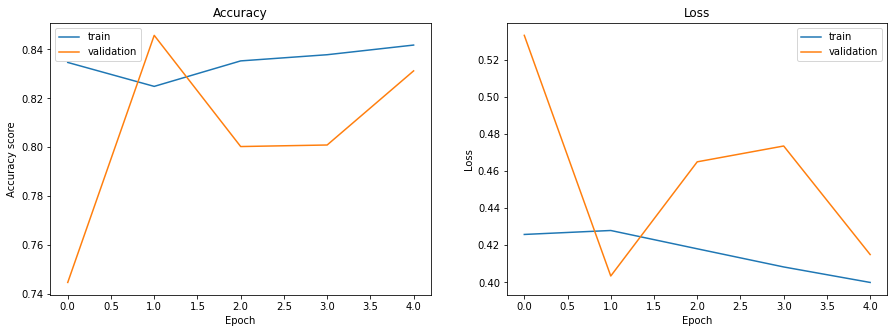

In [ ]:
plotTrainingHistory(history_model_1)

Despite of reducing the dataset to 10%, and then to 1% of its size, the required fitting time remaines the same.

---

### Add autoencoder

In [ ]:
model2 = models.Sequential()
model2.add(layers.Conv2D(32, 5, padding='same', activation='relu', strides=(1, 1), input_shape=img_shape))
model2.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(1, 1)))
model2.add(layers.Conv2D(64, 5, activation='relu', strides=(1, 1)))
model2.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(1, 1)))
model2.add(layers.Conv2D(128, 5, activation='relu', strides=(1, 1)))
model2.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(1, 1)))

shape_before_flattening = (50, 50, 128)

model2.add(layers.Flatten())
model2.add(layers.Dense(64, activation="relu"))
model2.add(layers.Dense(64, activation="relu"))
model2.add(layers.Dense(2, activation="softmax"))

In [ ]:
model2.summary()

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_152 (Conv2D)         (None, 64, 64, 32)        2432      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_153 (Conv2D)         (None, 58, 58, 64)        51264     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 56, 56, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_154 (Conv2D)         (None, 52, 52, 128)       204928    
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 50, 50, 128)    

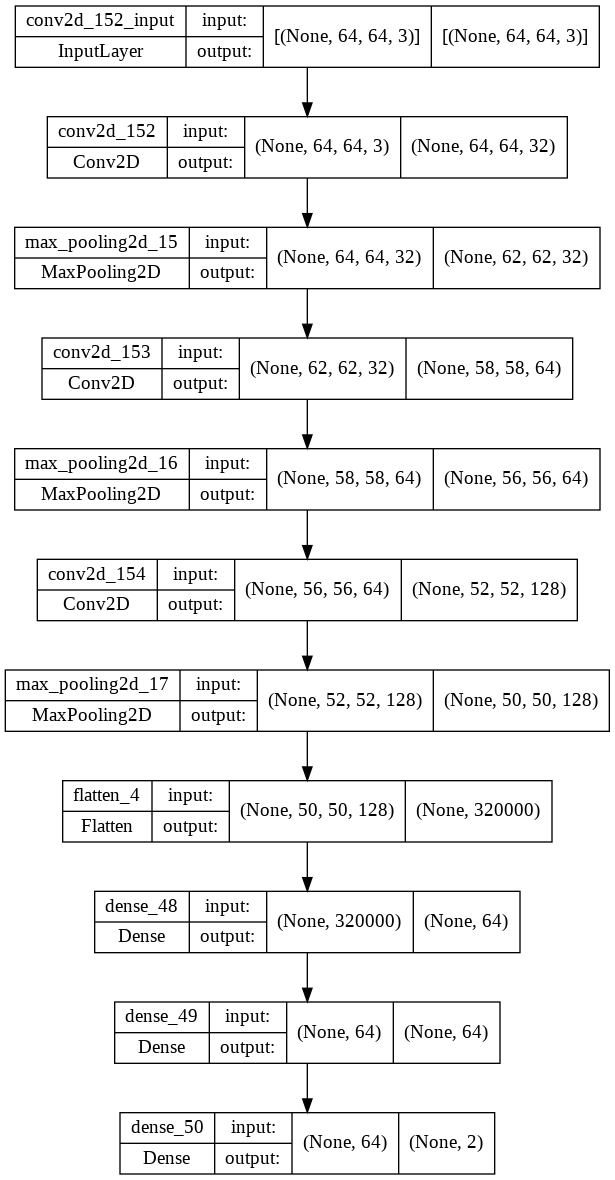

In [ ]:
plot_model(model2, show_shapes=True)

In [ ]:
decoder = models.Sequential()
decoder.add(layers.InputLayer(2))
decoder.add(layers.Dense(shape_before_flattening[0] * shape_before_flattening[1] * shape_before_flattening[2]))
decoder.add(layers.Reshape((shape_before_flattening[0], shape_before_flattening[1], shape_before_flattening[2])))
decoder.add(layers.Conv2D(128, 5, strides=(1, 1), activation='relu'))
decoder.add(layers.Conv2D(64, 5, strides=(1, 1), activation='relu'))
decoder.add(layers.Conv2D(32, 5, strides=(1, 1), activation='relu'))
decoder.add(layers.Conv2D(32, 5, strides=(1, 1), activation='relu'))
decoder.add(layers.UpSampling2D(2))
decoder.add(layers.Conv2D(3, 5, strides=(1, 1), activation='softmax'))

In [ ]:
decoder.summary()

Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_51 (Dense)            (None, 320000)            960000    
                                                                 
 reshape_38 (Reshape)        (None, 50, 50, 128)       0         
                                                                 
 conv2d_155 (Conv2D)         (None, 46, 46, 128)       409728    
                                                                 
 conv2d_156 (Conv2D)         (None, 42, 42, 64)        204864    
                                                                 
 conv2d_157 (Conv2D)         (None, 38, 38, 32)        51232     
                                                                 
 conv2d_158 (Conv2D)         (None, 34, 34, 32)        25632     
                                                                 
 up_sampling2d_53 (UpSamplin  (None, 68, 68, 32)     

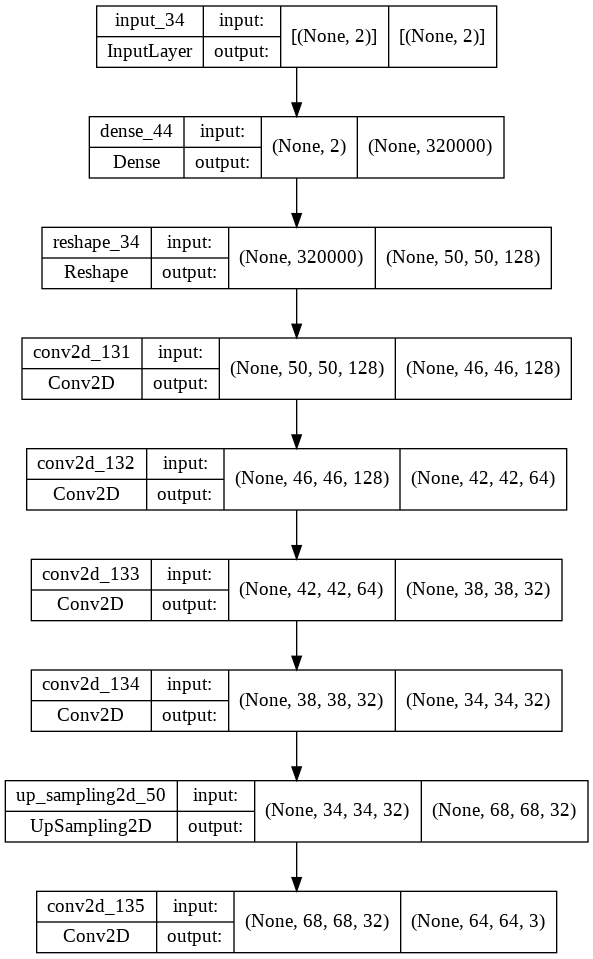

In [ ]:
plot_model(decoder, show_shapes=True)

In [ ]:
autoencoder = Model(inputs=model2.input, outputs=decoder(model2.outputs))

In [ ]:
autoencoder.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_123_input (InputLaye  [(None, 64, 64, 3)]      0         
 r)                                                              
                                                                 
 conv2d_123 (Conv2D)         (None, 64, 64, 32)        2432      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_124 (Conv2D)         (None, 58, 58, 64)        51264     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                           

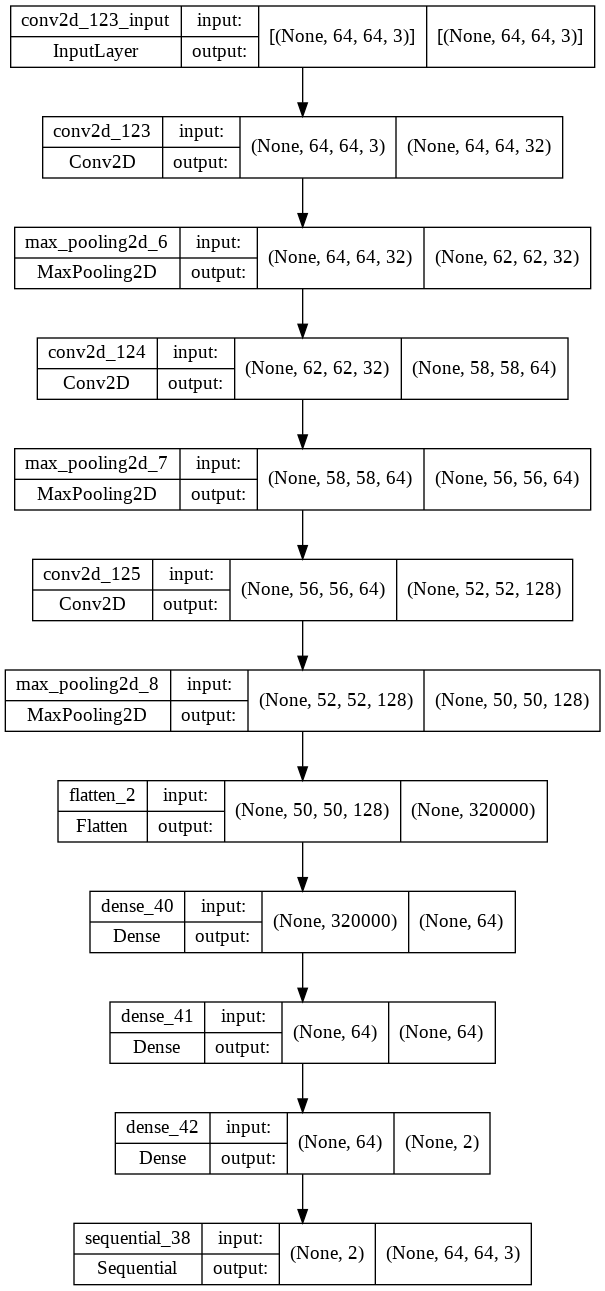

In [ ]:
plot_model(autoencoder, show_shapes=True)

In [ ]:
autoencoder.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics= ["accuracy"])

In [ ]:
history_autoencoder = autoencoder.fit(X_trainset, epochs=25, verbose=1, 
                                      validation_data=(X_testset),
                                      callbacks=[earlystopping])

Epoch 1/25


InvalidArgumentError: ignored

`sparse_categorical_crossentropy` to `categorical_crossentropy`, via: [stackoverflow](https://stackoverflow.com/a/72443148/10534633)

In [ ]:
autoencoder.compile(optimizer='adam', loss="categorical_crossentropy", metrics= ["accuracy"])

In [ ]:
history_autoencoder = autoencoder.fit(X_trainset, epochs=25, verbose=1, 
                                      validation_data=(X_testset),
                                      callbacks=[earlystopping])

Epoch 1/25


ValueError: ignored

Checking if it is not a problem with the `tf.data` dataset by changing `tf.keras.Model.fit` arguments to separate *inputs* and *targets* arrays.

The quickest method to split the dataset I found [here](https://stackoverflow.com/a/70488354/10534633).

In [ ]:
train_ds = X_trainset.unbatch()
images = list(train_ds.map(lambda x, y: x))
labels = list(train_ds.map(lambda x, y: y))

In [ ]:
test_ds = X_testset.unbatch()
images_test = list(test_ds.map(lambda x, y: x))
labels_test = list(test_ds.map(lambda x, y: y))

via: [stackoverflow](https://stackoverflow.com/a/48851837/10534633)

In [ ]:
labels = np.asarray(labels).astype('float32').reshape((-1, 1))
labels_test = np.asarray(labels_test).astype('float32').reshape((-1, 1))

In [ ]:
history_autoencoder = autoencoder.fit(x=np.array(images), y=labels, epochs=25, verbose=1, 
                                      validation_data=(np.array(images_test), labels_test),
                                      callbacks=[earlystopping])

Epoch 1/25


ValueError: ignored

I was not able to fix the autoencoder.

I found a thread on *GitHub* with similar error and I hope I will receive any advice [there](https://github.com/keras-team/keras/issues/16228).